In [56]:
## import essential modules 
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import qumcmc 
from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.basic_utils import plot_bargraph_desc_order, MCMCChain, MCMCState
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# define the model
np.random.seed(610358)# should always be in the same cell!  
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= (n_spins, n_spins) )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')

            MODEL : my_model
Non-zero Interactions (J) :  90
Non-zero Bias (h) :  9
---------------------------------------------
Average Interaction Strength <|J|> :  0.5966799999999999
Average Bias Strength <|h|>:  0.5010000000000001
alpha :  0.5606804251097042
model beta :  1.0
---------------------------------------------


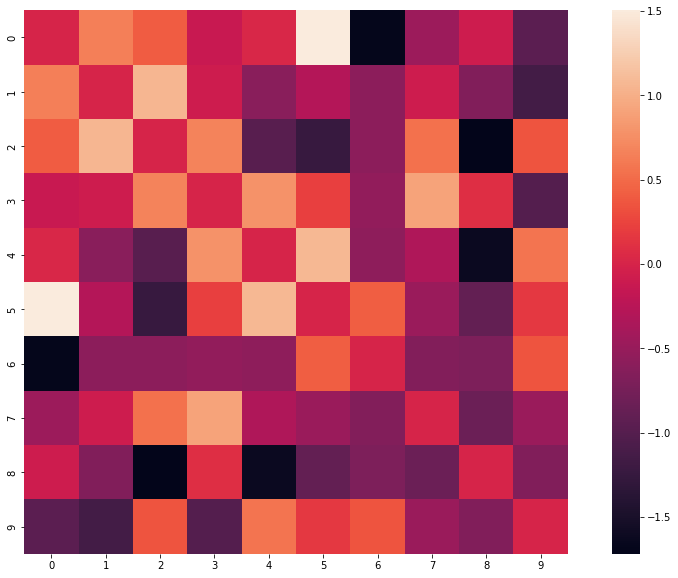

In [3]:
model.model_summary()

In [4]:
# import snakeviz

In [4]:
## set current beta
beta = 1.100209
## run exact sampling over all possible configurations 
model.run_exact_sampling(beta)

Running Exact Sampling | Model beta :  1.100209


running over all possible configurations: 100%|██████████| 1024/1024 [00:00<00:00, 19364.49it/s]

saving distribution to model ...


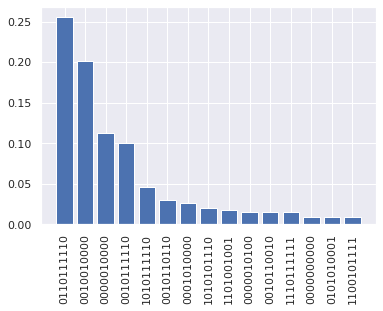

In [8]:
## get the distribution from model
bpd = model.boltzmann_pd
## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)

# run classical mcmc

In [9]:
steps = 10000
mcmc_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    # return_last_n_states=10,
    temperature=1/beta,
)

starting with:  0101110110 with energy: 1.2780000000000005


running MCMC steps ...: 100%|██████████| 10000/10000 [00:01<00:00, 7147.03it/s]


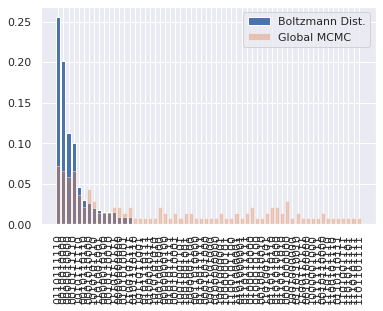

In [10]:
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)
plot_bargraph_desc_order(mcmc_chain.get_accepted_dict(), plot_first_few= -1, normalise_complete_data=True, label= 'Global MCMC', alpha=0.4)
plt.legend()
plt.show()

# Run quantum enhanced mcmc

In [11]:
steps = 1000
qamcmc_chain =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

starting with:  0000110110 with energy: -4.029999999999999
MCMCChain()


runnning quantum MCMC steps . ..: 100%|██████████| 1000/1000 [00:34<00:00, 29.16it/s]


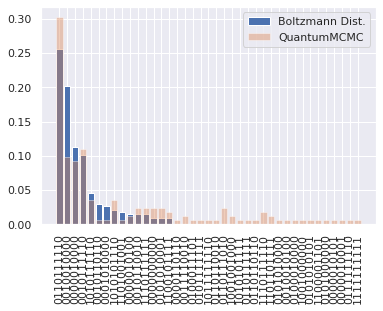

In [12]:
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)
plot_bargraph_desc_order(qamcmc_chain.get_accepted_dict(), plot_first_few= -1, normalise_complete_data=True, label= 'QuantumMCMC', alpha=0.4)
plt.legend()
plt.show()

In [13]:
qamcmc_chain.get_accepted_dict(),mcmc_chain.get_accepted_dict()

(Counter({'0000110110': 1,
          '0011110010': 2,
          '0100011101': 1,
          '0101111111': 1,
          '1011111110': 1,
          '0110110010': 1,
          '0110111010': 4,
          '1010101110': 6,
          '0010110010': 4,
          '1010111110': 6,
          '1110111111': 4,
          '1101001001': 1,
          '1001001000': 2,
          '0000000000': 4,
          '1100101111': 3,
          '0010111110': 19,
          '0110111110': 52,
          '1010101111': 1,
          '0110111111': 1,
          '0110110110': 1,
          '1110111110': 3,
          '0010110110': 1,
          '0010010000': 17,
          '0000010000': 16,
          '1101101111': 2,
          '0101010001': 4,
          '0101010000': 1,
          '0000010100': 2,
          '0010010100': 1,
          '0001010000': 1,
          '0100010000': 1,
          '1001000000': 1,
          '0101010101': 1,
          '1100001101': 1,
          '0101000000': 1,
          '0000010101': 1,
          '0000010001': 

### KL divergence

In [17]:
from tqdm import tqdm
from qumcmc.prob_dist import js_divergence, kl_divergence

In [18]:
def calculate_running_kl_divergence(actual_boltz_distn, mcmc_chain: MCMCChain, skip_steps: int = 1):
    num_nhops = len(mcmc_chain.states)
    
    list_kl_after_each_step=[]

    for step_num in tqdm(range(1, num_nhops, skip_steps)): ##pafloxy : starting at 100 instead of 0 , neglecting effect of intital states

        temp_distn_model = mcmc_chain.get_accepted_dict(normalize=True, until_index=step_num)

        kl_temp=kl_divergence(actual_boltz_distn,temp_distn_model)

        list_kl_after_each_step.append(kl_temp)


    return list_kl_after_each_step

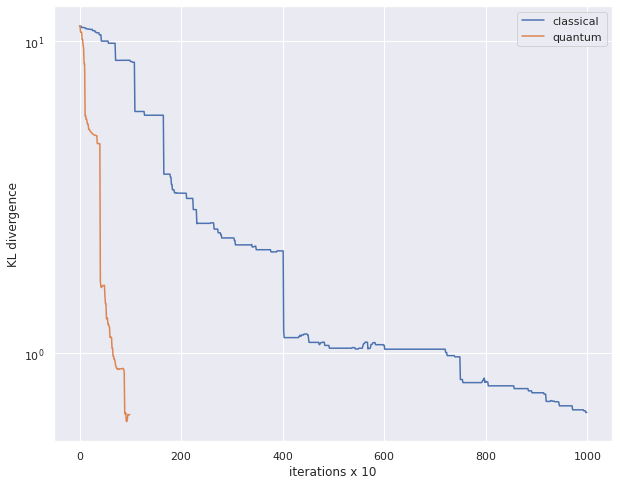

In [15]:
plt.figure(figsize=(10,8))
plt.plot(all_classical_js, label= 'classical')
plt.plot(all_quantum_js, label= 'quantum')
plt.xlabel(f"iterations x {skip_steps}")
plt.ylabel("JS divergence")
plt.yscale("log")
plt.legend()
plt.show()

In [47]:
model.get_observable_expectation( magnetization_of_state )

-0.9523090460470023

In [50]:
from qumcmc.prob_dist import *
def calculate_runnning_magnetisation(mcmc_chain: MCMCChain, skip_steps: int = 1) -> list:    
    num_nhops = len(mcmc_chain.states)

    list_mag_after_each_step=[]    

    magnetisation_dict = dict([ (state, magnetization_of_state(state) ) for state  in  mcmc_chain.accepted_states ])

    for step_num in tqdm(range(1, num_nhops, skip_steps)): ##pafloxy : starting at 100 instead of 0 , neglecting effect of intital states

        temp_distn_model = DiscreteProbabilityDistribution( mcmc_chain.get_accepted_dict(normalize=True, until_index=step_num) )
        
        mag_temp = temp_distn_model.expectation(magnetisation_dict)

        list_mag_after_each_step.append(mag_temp)
    
    return list_mag_after_each_step


In [51]:
calculate_runnning_magnetisation(qamcmc_chain)

100%|██████████| 1000/1000 [00:00<00:00, 1969.67it/s]


[-2.0,
 -2.0,
 -2.0,
 -2.0,
 -2.0,
 -2.0,
 -1.0,
 -0.6666666666666666,
 -0.5,
 0.8000000000000002,
 1.6666666666666667,
 1.6666666666666667,
 1.4285714285714284,
 1.5,
 1.5,
 1.5555555555555556,
 1.5555555555555556,
 1.6000000000000003,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.2727272727272725,
 1.3333333333333333,
 1.3333333333333333,
 1.3333333333333333,
 1.3333333333333333,
 1.3333333333333333,
 1.5384615384615385,
 1.5384615384615385,
 1.5384615384615385,
 1.5384615384615385,
 1.7142857142857142,
 1.7142857142857142,
 1.7142857142857142,
 1.7142857142857142,
 1.7142857142857142,
 1.7142

100%|██████████| 1000/1000 [00:00<00:00, 3353.28it/s]


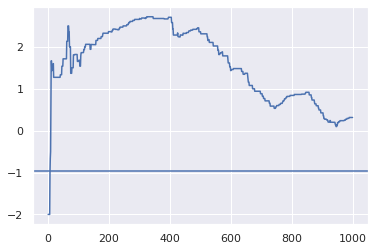

In [52]:
plt.plot(calculate_runnning_magnetisation(qamcmc_chain))
plt.axhline(model.get_observable_expectation( magnetization_of_state ))

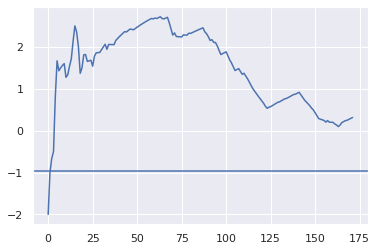

In [48]:
plt.plot(calculate_runnning_magnetisation(qamcmc_chain))
plt.axhline(model.get_observable_expectation( magnetization_of_state ))

In [18]:
from qumcmc.prob_dist import *

In [34]:
def kl_divergence(dict_p: dict, dict_q: dict, prelim_check:bool =  False):
    ''' 
    Returns KL divergence KL(p||q);

    Args:

    dict_p: distribution p ({random_variable: prob}),

    dict_q: distribution q ({random_variable: prob}),

    prelim_check: default 'True'. 
    If user is completely sure that 
    dict_p and dict_q have same keys and that both the distributions are
    normalised then user can set it to 'False'.
    '''
    if prelim_check:
        #check for whether or not dict_p and dict_q have same keys
        keys_p,keys_q=list(dict_p.keys()),list(dict_q.keys())# reason why not inplace
        keys_p.sort();keys_q.sort()
        assert keys_p==keys_q, "keys of both the dictionaries dont match!"

        # check for whether values add to 1.
        eps=1e-6
        sum_vals_p=np.sum(list(dict_p.values()))
        assert np.abs(sum_vals_p-1.0)<=eps, "sum of values of dict_p must be 1."
        sum_vals_q=np.sum(list(dict_q.values()))
        assert np.abs(sum_vals_q-1.0)<=eps, "sum of values of dict_q must be 1."
    
    #prep for caln
    p=DiscreteProbabilityDistribution(dict_p).index_sorted_dict()
    q=DiscreteProbabilityDistribution(dict_q).index_sorted_dict()
    p_arr,q_arr=np.array(list(p.values())).reshape((len(p))), np.array(list(q.values())).reshape((len(q)))
    return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))

    # KL = 0
    # for bitstring, p_data in dict_p.items():
    #     if bitstring in dict_q.keys():
    #         KL += p_data * np.log(p_data) - p_data * np.log(
    #             max(1e-6, dict_q[bitstring])
    #         )
    #     else:
    #         KL += p_data * np.log(p_data) - p_data * np.log(1e-6)
    # return KL

def js_divergence(dict_p:dict,dict_q:dict, prelim_check=True):
    ''' 
    Returns JS divergence JS(p||q);
    
    Args:
    dict_p: distribution p ({random_variable: prob}),

    dict_q: distribution q ({random_variable: prob}),

    prelim_check: default 'True'. 
    If user is completely sure that 
    dict_p and dict_q have same keys and that both the distributions are
    normalised then user can set it to 'False'.
    '''
    if prelim_check:
        #check for whether or not dict_p and dict_q have same keys
        keys_p,keys_q=list(dict_p.keys()),list(dict_q.keys())
        keys_p.sort();keys_q.sort()
        assert keys_p==keys_q, "keys of both the dictionaries dont match!"
        
        # check for whether values add to 1.
        eps=1e-6
        sum_vals_p=np.sum(list(dict_p.values()))
        assert np.abs(sum_vals_p-1.0)<=eps, "sum of values of dict_p must be 1."
        sum_vals_q=np.sum(list(dict_q.values()))
        assert np.abs(sum_vals_q-1.0)<=eps, "sum of values of dict_q must be 1."

    #prep for caln
    p=DiscreteProbabilityDistribution(dict_p).index_sorted_dict()
    q=DiscreteProbabilityDistribution(dict_q).index_sorted_dict()
    p_arr,q_arr=np.array(list(p.values())).reshape((len(p))), np.array(list(q.values())).reshape((len(q)))
    val_m = np.round(0.5 * (p_arr + q_arr),decimals=8)
    #print("val_m:");print(val_m)
    m=dict(zip(list(p.keys()),val_m))
    #print("m:");print(m)
    return 0.5 * (kl_divergence(p, m, prelim_check=False) +  kl_divergence(q, m, prelim_check=False))


In [38]:
p = {'a': 0.4, 'b':0.002, 'c': 0.4} ; q = {'a':0.4, 'b': 0.01, 'c': 0.6-0.01}
print('p: ',p)
print('q: ',q)

p:  {'a': 0.4, 'b': 0.2, 'c': 0.4}
q:  {'a': 0.4, 'b': 0.01, 'c': 0.59}


In [39]:
kl_divergence(q,p)

0.2876025421910689

In [40]:
kl_divergence(q,p, prelim_check= True)

0.2876025421910689

In [26]:
js_divergence(p,q)

TypeError: kl_divergence() got an unexpected keyword argument 'prelim_check'